In [2]:
# カイ二乗検定（AI判定 True/False と属性 0/1 の関連）
# ついている属性全てに対して，AIの判定結果True/Falseとの関係を調べる
# さらに、正解ラベル（例: Damaged / Intact）ごとに分けて検定を行う
# 使い方:
# 1) 下の csv_path, label_col に加えて truth_col とそのカテゴリ値を編集してください
# 2) 実行すると、各属性ごとの分割表、カイ二乗統計量、p値、効果量(Cramer's V)、多重比較補正結果を、正解ラベルごとに表示します

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from pathlib import Path

# ===== ユーザーが設定するパラメータ =====
# CSVファイルへのパス
csv_path = r"C:\\Users\\kyohe\\Aerial_Photo_Classifier\\20250826Data\\Results\\attr_results_20250827_2140.csv"  # 例: r"C:\\Users\\kyohe\\Aerial_Photo_Classifier\\20241023Data\\Results\\classification_results_20250422_1843.csv"
# 出力ファイルへのパス（.csv または .txt を推奨）
output_path = r"C:\\Users\\kyohe\\Aerial_Photo_Classifier\\20250826Data\\Results\\chi2_results_20250827_2140.csv"  # 例: r"C:\\Users\\kyohe\\Aerial-Photo-Classifier\\Results\\chi2_summary.csv"

# AIの判定結果(True/False: 正解/不正解)の列名
label_col = "Correct"  # 例: "Correct" など T/F を格納する列

# 正解ラベル（GT）の列名と、Damaged/Intact に相当する値
truth_col = "TrueLabel"  # 例: "TrueLabel" や "GT"
truth_value_damaged = "Damaged"  # 正解ラベルが Damaged を表す値
truth_value_intact = "Intact"    # 正解ラベルが Intact を表す値

# 調べたい属性列（0/1のカテゴリカル想定）
attribute_cols = [
    "NotExposed",
    "NotCenteredDamage",
    "House",
    "CroppedOff",
    "Shady",
    "Dark",
    "Cloudy",
    "Tree",
    "Snow",
    "Obj",
    "Seam",
    "IncludesDamage",
]
# =====================================

# 0/1, True/False, '0'/'1', 'True'/'False' を 0/1 に統一
def to_binary_series(s: pd.Series) -> pd.Series:
    mapping = {
        True: 1, False: 0,
        "True": 1, "False": 0,
        "TRUE": 1, "FALSE": 0,
        "true": 1, "false": 0,
        1: 1, 0: 0,
        "1": 1, "0": 0,
    }
    return s.map(mapping).astype("Int64")

# Benjamini-Hochberg (FDR) の簡易実装
# 戻り値: boolean配列(有意かどうか), 補正後p値
def benjamini_hochberg(pvals, alpha=0.05):
    pvals = np.asarray(pvals, dtype=float)
    n = pvals.size
    order = np.argsort(pvals)
    ranked_p = pvals[order]
    bh_crit = (np.arange(1, n + 1) / n) * alpha
    # 最大の i で p(i) <= (i/m)*alpha を満たす点まで有意
    is_sig_sorted = ranked_p <= bh_crit
    if is_sig_sorted.any():
        max_i = np.where(is_sig_sorted)[0].max()
        is_sig_sorted[: max_i + 1] = True
        is_sig_sorted[max_i + 1 :] = False
    # 補正後p値（q値）
    qvals = ranked_p * n / (np.arange(1, n + 1))
    qvals = np.minimum.accumulate(qvals[::-1])[::-1]
    # 元の順序に戻す
    is_sig = np.empty_like(is_sig_sorted)
    is_sig[order] = is_sig_sorted
    qvals_out = np.empty_like(qvals)
    qvals_out[order] = qvals
    return is_sig, qvals_out

# Cramer's V（2x2ならPhi係数と同等）
def cramers_v_from_table(table: np.ndarray) -> float:
    chi2, _, _, _ = chi2_contingency(table, correction=True)
    n = table.sum()
    r, k = table.shape
    phi2 = chi2 / n
    # r,k の小さい方-1 を使う（2x2で1）
    return float(np.sqrt(phi2 / max(min(r - 1, k - 1), 1)))

# 入力チェック
csv_path = Path(csv_path)
if not csv_path.exists():
    raise FileNotFoundError(f"CSVが見つかりません: {csv_path}")

# 読み込み
df = pd.read_csv(csv_path)

if label_col not in df.columns:
    raise KeyError(f"label_col '{label_col}' がCSVに見つかりません。列名を確認してください。")

# ラベルと属性を0/1に統一
label = to_binary_series(df[label_col])

available_attrs = [c for c in attribute_cols if c in df.columns]
missing_attrs = [c for c in attribute_cols if c not in df.columns]
if missing_attrs:
    print(f"警告: 次の属性列が見つかりませんでした -> {missing_attrs}")

attr_data = {c: to_binary_series(df[c]) for c in available_attrs}

# グループ定義（正解ラベルごと）。truth_col が無ければ全体のみ
groups = []
if truth_col in df.columns:
    groups = [
        (f"{truth_col}={truth_value_damaged}", df[truth_col] == truth_value_damaged),
        (f"{truth_col}={truth_value_intact}", df[truth_col] == truth_value_intact),
    ]
else:
    print(f"警告: truth_col '{truth_col}' が見つかりません。全体（未分割）で実行します。")
    groups = [("All", pd.Series([True] * len(df), index=df.index))]

aggregated_results = []

for group_name, group_mask in groups:
    print(f"\n==============================")
    print(f"=== カイ二乗検定 結果 (Yates補正あり, 2x2分割) | グループ: {group_name} ===")

    test_results = []  # このグループの各属性の結果

    for c in available_attrs:
        x = attr_data[c]
        valid = group_mask & label.notna() & x.notna()
        if valid.sum() == 0:
            print(f"\n[{c}] 有効データなしのためスキップ (グループ={group_name})")
            test_results.append({
                "group": group_name,
                "attr": c,
                "chi2": np.nan,
                "p": np.nan,
                "cramers_v": np.nan,
                "n": 0,
            })
            continue

        label_v = label[valid].astype(int)
        x_v = x[valid].astype(int)

        # 分割表（行: label 0/1, 列: attr 0/1）
        table = pd.crosstab(label_v, x_v).reindex(index=[0, 1], columns=[0, 1], fill_value=0)
        table_np = table.values

        # 期待度数が0になりうる形（行/列の合計が0）は検定不可
        if (
            table_np.sum() == 0
            or (table_np < 0).any()
            or (table_np.sum(axis=0) == 0).any()
            or (table_np.sum(axis=1) == 0).any()
        ):
            print(f"\n[{c}] 行または列和が0のためカイ二乗検定をスキップ (グループ={group_name})")
            test_results.append({
                "group": group_name,
                "attr": c,
                "chi2": np.nan,
                "p": np.nan,
                "cramers_v": np.nan,
                "n": int(valid.sum()),
            })
            continue

        try:
            chi2, p, dof, expected = chi2_contingency(table_np, correction=True)
            v = cramers_v_from_table(table_np)
        except ValueError as e:
            print(f"\n[{c}] 期待度数に0が含まれるためスキップ (グループ={group_name}) | {e}")
            test_results.append({
                "group": group_name,
                "attr": c,
                "chi2": np.nan,
                "p": np.nan,
                "cramers_v": np.nan,
                "n": int(valid.sum()),
            })
            continue

        print(f"\n[{c}] グループ={group_name}")
        print("分割表 (行=AI正誤 0/1, 列=属性 0/1):")
        print(table)
        print(f"n={valid.sum()}, chi2={chi2:.4f}, dof={dof}, p={p:.6g}, Cramer's V={v:.4f}")

        test_results.append({
            "group": group_name,
            "attr": c,
            "chi2": float(chi2),
            "p": float(p),
            "cramers_v": float(v),
            "n": int(valid.sum()),
        })

    # 多重比較補正（グループ内で実施: Bonferroni と BH-FDR）
    results_df = pd.DataFrame(test_results)
    if not results_df.empty:
        pvals = results_df["p"].to_numpy()

        # Bonferroni
        m = np.isfinite(pvals).sum()
        bonf_p = np.where(np.isfinite(pvals), pvals * max(m, 1), np.nan)

        # BH-FDR
        bh_sig, bh_q = benjamini_hochberg(np.where(np.isfinite(pvals), pvals, 1.0), alpha=0.05)

        results_df["p_bonf"] = bonf_p
        results_df["bh_q"] = bh_q
        results_df["sig_0.05_raw"] = results_df["p"] <= 0.05
        results_df["sig_0.05_bonf"] = results_df["p_bonf"] <= 0.05
        results_df["sig_0.05_bh"] = bh_sig

        display_cols = [
            "group", "attr", "n", "chi2", "cramers_v", "p", "p_bonf", "bh_q",
            "sig_0.05_raw", "sig_0.05_bonf", "sig_0.05_bh",
        ]
        print("\n=== まとめ（多重比較補正を含む）: グループ別 ===")
        try:
            from IPython.display import display
            display(results_df[display_cols].sort_values(["group", "p"]))
        except Exception:
            print(results_df[display_cols].sort_values(["group", "p"]).to_string(index=False))

        # 集約: 保存は最後にまとめて行う
        aggregated_results.append(results_df[display_cols])
    else:
        print(f"グループ {group_name} に有効な結果がありませんでした。")




=== カイ二乗検定 結果 (Yates補正あり, 2x2分割) | グループ: TrueLabel=Damaged ===

[NotExposed] グループ=TrueLabel=Damaged
分割表 (行=AI正誤 0/1, 列=属性 0/1):
NotExposed    0   1
Correct            
0            12  26
1           116  68
n=222, chi2=11.5157, dof=1, p=0.000690106, Cramer's V=0.2278

[NotCenteredDamage] グループ=TrueLabel=Damaged
分割表 (行=AI正誤 0/1, 列=属性 0/1):
NotCenteredDamage    0   1
Correct                   
0                   26  12
1                  134  50
n=222, chi2=0.1242, dof=1, p=0.724508, Cramer's V=0.0237

[House] 行または列和が0のためカイ二乗検定をスキップ (グループ=TrueLabel=Damaged)

[CroppedOff] グループ=TrueLabel=Damaged
分割表 (行=AI正誤 0/1, 列=属性 0/1):
CroppedOff    0  1
Correct           
0            35  3
1           175  9
n=222, chi2=0.1235, dof=1, p=0.725283, Cramer's V=0.0236

[Shady] グループ=TrueLabel=Damaged
分割表 (行=AI正誤 0/1, 列=属性 0/1):
Shady     0    1
Correct         
0        18   20
1        84  100
n=222, chi2=0.0002, dof=1, p=0.988435, Cramer's V=0.0010

[Dark] グループ=TrueLabel=Damaged
分割表 (行=AI正誤 0/1, 列=属性 

,group,attr,n,chi2,cramers_v,p,p_bonf,bh_q,sig_0.05_raw,sig_0.05_bonf,sig_0.05_bh
0,TrueLabel=Damaged,NotExposed,222,11.515707,0.227755,0.000690,0.006901,0.008281,True,True,True
9,TrueLabel=Damaged,Obj,222,3.134065,0.118817,0.076672,0.766724,0.460034,False,False,False
8,TrueLabel=Damaged,Snow,222,0.598403,0.051918,0.439188,4.391879,1.000000,False,False,False
6,TrueLabel=Damaged,Cloudy,222,0.182632,0.028682,0.669121,6.691213,1.000000,False,False,False
1,TrueLabel=Damaged,NotCenteredDamage,222,0.124215,0.023654,0.724508,7.245077,1.000000,False,False,False
3,TrueLabel=Damaged,CroppedOff,222,0.123487,0.023585,0.725283,7.252829,1.000000,False,False,False
5,TrueLabel=Damaged,Dark,222,0.053838,0.015573,0.816515,8.165149,1.000000,False,False,False
10,TrueLabel=Damaged,Seam,222,0.000435,0.001400,0.983361,9.833612,1.000000,False,False,False
4,TrueLabel=Damaged,Shady,222,0.000210,0.000973,0.988435,9.884348,1.000000,False,False,False
7,TrueLabel=Damaged,Tree,222,0.000000,0.000000,1.000000,10.000000,1.000000,False,False,False



=== カイ二乗検定 結果 (Yates補正あり, 2x2分割) | グループ: TrueLabel=Intact ===

[NotExposed] 行または列和が0のためカイ二乗検定をスキップ (グループ=TrueLabel=Intact)

[NotCenteredDamage] 行または列和が0のためカイ二乗検定をスキップ (グループ=TrueLabel=Intact)

[House] グループ=TrueLabel=Intact
分割表 (行=AI正誤 0/1, 列=属性 0/1):
House      0   1
Correct         
0          9  32
1        117  64
n=222, chi2=23.1121, dof=1, p=1.52825e-06, Cramer's V=0.3227

[CroppedOff] グループ=TrueLabel=Intact
分割表 (行=AI正誤 0/1, 列=属性 0/1):
CroppedOff    0  1
Correct           
0            41  0
1           180  1
n=222, chi2=0.0000, dof=1, p=1, Cramer's V=0.0000

[Shady] グループ=TrueLabel=Intact
分割表 (行=AI正誤 0/1, 列=属性 0/1):
Shady      0   1
Correct         
0         12  29
1        128  53
n=222, chi2=22.9086, dof=1, p=1.69892e-06, Cramer's V=0.3212

[Dark] グループ=TrueLabel=Intact
分割表 (行=AI正誤 0/1, 列=属性 0/1):
Dark       0   1
Correct         
0         37   4
1        146  35
n=222, chi2=1.5090, dof=1, p=0.219298, Cramer's V=0.0824

[Cloudy] グループ=TrueLabel=Intact
分割表 (行=AI正誤 0/1, 列=属性 0/1):

,group,attr,n,chi2,cramers_v,p,p_bonf,bh_q,sig_0.05_raw,sig_0.05_bonf,sig_0.05_bh
2,TrueLabel=Intact,House,222,23.112112,0.322659,0.000002,0.000015,0.000010,True,True,True
4,TrueLabel=Intact,Shady,222,22.908574,0.321235,0.000002,0.000017,0.000010,True,True,True
11,TrueLabel=Intact,IncludesDamage,222,8.497529,0.195645,0.003556,0.035563,0.014225,True,True,True
9,TrueLabel=Intact,Obj,222,4.333374,0.139713,0.037372,0.373721,0.112116,True,False,False
6,TrueLabel=Intact,Cloudy,222,2.695854,0.110197,0.100610,1.006096,0.241463,False,False,False
5,TrueLabel=Intact,Dark,222,1.508959,0.082445,0.219298,2.192981,0.438596,False,False,False
8,TrueLabel=Intact,Snow,222,0.241789,0.033002,0.622917,6.229170,1.000000,False,False,False
7,TrueLabel=Intact,Tree,222,0.083572,0.019402,0.772513,7.725134,1.000000,False,False,False
3,TrueLabel=Intact,CroppedOff,222,0.000000,0.000000,1.000000,10.000000,1.000000,False,False,False
10,TrueLabel=Intact,Seam,222,0.000000,0.000000,1.000000,10.000000,1.000000,False,False,False


In [ ]:
# 結果をまとめて保存（CSV または TXT）する用のセル
from pathlib import Path

if len(aggregated_results) > 0:
    final_df = pd.concat(aggregated_results, axis=0, ignore_index=True)
    try:
        out_path = Path(output_path)
        if str(out_path) == "" or str(out_path).strip() == "":
            print("output_path が空です。保存をスキップしました。")
        else:
            out_path.parent.mkdir(parents=True, exist_ok=True)
            if str(out_path).lower().endswith('.csv'):
                final_df.to_csv(out_path, index=False, encoding='utf-8-sig')
                print(f"保存しました: {out_path}")
            elif str(out_path).lower().endswith('.txt'):
                # 表形式をテキストで保存
                with open(out_path, 'w', encoding='utf-8') as f:
                    f.write(final_df.sort_values(["group", "p"]).to_string(index=False))
                print(f"保存しました: {out_path}")
            else:
                # 未指定・未対応拡張子は CSV へ
                csv_path = out_path.with_suffix('.csv')
                final_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
                print(f"拡張子未対応のため CSV で保存しました: {csv_path}")
    except Exception as e:
        print(f"結果の保存に失敗しました: {e}")
else:
    print("保存対象となる結果がありませんでした。")



保存しました: C:\Users\kyohe\Aerial-Photo-Classifier\20250826Data\Results\chi2_results_20250827_2140.csv


In [3]:
# 多重ロジスティック回帰（属性 -> AI正誤[Correct] の二値予測）を Damaged/Intact 別に実行し、CSVと係数プロットPNGを出力
import numpy as np
import pandas as pd
from pathlib import Path

# 係数の95%CI算出のため statsmodels を使用（利用不可なら簡易学習のみ）
try:
    import statsmodels.api as sm
    HAS_SM = True
except Exception:
    HAS_SM = False

import matplotlib.pyplot as plt

# 入力となるデータ確認と前処理
if 'attribute_cols' not in globals():
    raise RuntimeError('attribute_cols が見つかりません。先頭セルを先に実行してください。')
if 'label' not in globals():
    raise RuntimeError('label が見つかりません。先頭セルを先に実行してください。')
if 'attr_data' not in globals():
    # 先頭セル未実行時のフォールバック
    available_attrs = [c for c in attribute_cols if c in df.columns]
    attr_data = {c: to_binary_series(df[c]) for c in available_attrs}

# 属性データフレームを作成（行揃え）
attr_df = pd.DataFrame({c: attr_data[c] for c in available_attrs})

# グループ（Damaged/Intact）定義の再確認
if 'groups' not in globals() or not isinstance(groups, list) or len(groups) == 0:
    if truth_col in df.columns:
        groups = [
            (f"{truth_col}={truth_value_damaged}", df[truth_col] == truth_value_damaged),
            (f"{truth_col}={truth_value_intact}", df[truth_col] == truth_value_intact),
        ]
    else:
        groups = [("All", pd.Series([True] * len(df), index=df.index))]

# 出力先ディレクトリ決定（CSV/PNG 共通）
if 'output_path' in globals() and isinstance(output_path, str) and len(output_path.strip()) > 0:
    _base = Path(output_path)
    _out_dir = _base.parent
else:
    _out_dir = Path(csv_path).parent
_out_dir.mkdir(parents=True, exist_ok=True)

logit_rows = []

for group_name, group_mask in groups:
    # 有効行: グループ内 且つ 欠損のない行
    valid = group_mask & label.notna() & attr_df.notna().all(axis=1)
    if valid.sum() < 3:
        print(f"[Logit] グループ={group_name}: 有効データが少ないためスキップ (n={int(valid.sum())})")
        continue

    y = label[valid].astype(int).to_numpy()
    X = attr_df.loc[valid, available_attrs].astype(int).copy()

    # 定数（全0/全1など）で変動がない説明変数は除外
    varying_cols = [c for c in X.columns if X[c].nunique(dropna=True) > 1]
    X = X[varying_cols]

    if X.shape[1] == 0:
        print(f"[Logit] グループ={group_name}: 変動のある属性が無くスキップ")
        continue

    # y が片側クラスのみのときは学習不可
    if np.unique(y).size < 2:
        print(f"[Logit] グループ={group_name}: 目的変数が単一クラスのためスキップ")
        continue

    # statsmodels でロジスティック回帰（係数CI取得）
    if not HAS_SM:
        print(f"[Logit] statsmodels が利用できないため、95%CIを算出できません（グループ={group_name}）")
        continue

    try:
        X_const = sm.add_constant(X, has_constant='add')
        model = sm.Logit(y, X_const)
        res = model.fit(disp=False)
    except Exception as e:
        print(f"[Logit] グループ={group_name}: 学習に失敗しました -> {e}")
        continue

    params = res.params
    conf = res.conf_int(alpha=0.05)
    conf.columns = ['coef_ci_low', 'coef_ci_high']
    summary_df = pd.concat([params.rename('coef'), conf], axis=1)

    # メタ情報
    n_samples = int(valid.sum())
    pos_rate = float(y.mean())
    num_features = int(X.shape[1])

    # 係数・オッズ比とCIを記録（定数項と各特徴量）
    for feat in summary_df.index.tolist():
        c = float(summary_df.loc[feat, 'coef'])
        lo = float(summary_df.loc[feat, 'coef_ci_low'])
        hi = float(summary_df.loc[feat, 'coef_ci_high'])
        row = {
            'group': group_name,
            'feature': feat,
            'coef': c,
            'odds_ratio': float(np.exp(c)),
            'coef_ci_low': lo,
            'coef_ci_high': hi,
            'odds_ci_low': float(np.exp(lo)),
            'odds_ci_high': float(np.exp(hi)),
            'n': n_samples,
            'positive_rate': pos_rate,
            'num_features': num_features,
        }
        # intercept 列名は 'const'
        if feat == 'const':
            row['intercept'] = c
        else:
            row['intercept'] = np.nan
        logit_rows.append(row)

    # 可視化（特徴量のみ、constは除外）
    coef_plot_df = summary_df.drop(index=[idx for idx in summary_df.index if idx == 'const'], errors='ignore').copy()
    if coef_plot_df.shape[0] > 0:
        plt.figure(figsize=(8, max(3, 0.35 * coef_plot_df.shape[0])))
        y_pos = np.arange(coef_plot_df.shape[0])
        coefs = coef_plot_df['coef'].to_numpy()
        ylabels = coef_plot_df.index.tolist()
        yerr = np.vstack([
            coefs - coef_plot_df['coef_ci_low'].to_numpy(),
            coef_plot_df['coef_ci_high'].to_numpy() - coefs
        ])
        plt.errorbar(coefs, y_pos, xerr=yerr, fmt='o', color='tab:blue', ecolor='gray', capsize=3)
        plt.yticks(y_pos, ylabels)
        plt.axvline(0.0, color='black', linewidth=1)
        plt.xlabel('Coefficient (log-odds) with 95% CI')
        plt.xlim(-5, 5)
        plt.title(f'Logistic Coefficients with 95% CI | {group_name}')
        plt.tight_layout()
        plt.plot()
        # ファイル名を安全化
        safe_group = (
            group_name.replace('=', '-').replace(':', '-').replace('/', '-')
            .replace('\\', '-').replace(' ', '_')
        )
        if 'output_path' in globals() and isinstance(output_path, str) and len(output_path.strip()) > 0:
            base = Path(output_path)
            png_path = _out_dir / f"{base.stem}_logit_coef_{safe_group}.png"
        else:
            png_path = _out_dir / f"logit_coef_{safe_group}.png"
        try:
            plt.savefig(png_path, dpi=200)
            print(f"係数プロットを保存しました: {png_path}")
        except Exception as e:
            print(f"係数プロットの保存に失敗しました（{group_name}）: {e}")
        finally:
            plt.close()

# 結果を DataFrame 化し、CSV 保存
if len(logit_rows) == 0:
    print('ロジスティック回帰の有効な結果がありませんでした（CI推定失敗/対象なし）。')
else:
    logit_df = pd.DataFrame(logit_rows)

    # 保存先決定
    try:
        if 'output_path' in globals() and isinstance(output_path, str) and len(output_path.strip()) > 0:
            base = Path(output_path)
            out_path = _out_dir / f"{base.stem}_logit.csv"
        else:
            out_path = _out_dir / 'logit_results.csv'

        logit_df.to_csv(out_path, index=False, encoding='utf-8-sig')
        print(f"ロジスティック回帰の結果を保存しました: {out_path}")
    except Exception as e:
        print(f"ロジスティック回帰の保存に失敗しました: {e}")



係数プロットを保存しました: C:\Users\kyohe\Aerial_Photo_Classifier\20250826Data\Results\chi2_results_20250827_2140_logit_coef_TrueLabel-Damaged.png
係数プロットを保存しました: C:\Users\kyohe\Aerial_Photo_Classifier\20250826Data\Results\chi2_results_20250827_2140_logit_coef_TrueLabel-Intact.png
ロジスティック回帰の結果を保存しました: C:\Users\kyohe\Aerial_Photo_Classifier\20250826Data\Results\chi2_results_20250827_2140_logit.csv


c:\Users\kyohe\Aerial_Photo_Classifier\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kyohe\AppData\Local\Temp\ipykernel_28324\1760319165.py:107: RuntimeWarning: overflow encountered in exp
  'odds_ci_high': float(np.exp(hi)),
c:\Users\kyohe\Aerial_Photo_Classifier\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kyohe\AppData\Local\Temp\ipykernel_28324\1760319165.py:107: RuntimeWarning: overflow encountered in exp
  'odds_ci_high': float(np.exp(hi)),


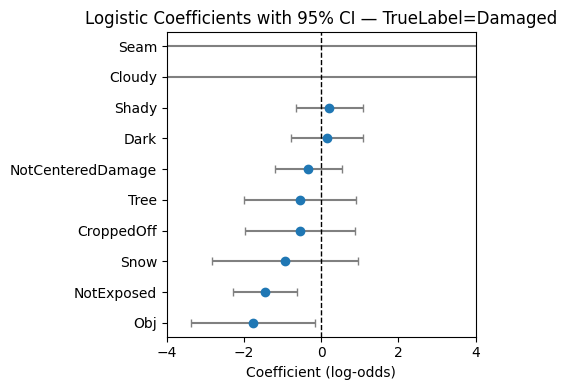

[Replot] saved: C:\Users\kyohe\Aerial_Photo_Classifier\20250826Data\Results\chi2_results_20250827_2140_logit_replot_TrueLabel-Damaged.png


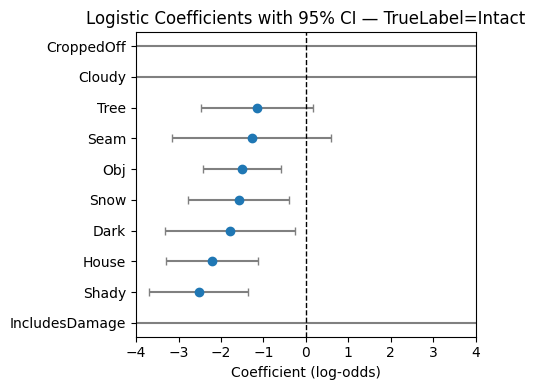

[Replot] saved: C:\Users\kyohe\Aerial_Photo_Classifier\20250826Data\Results\chi2_results_20250827_2140_logit_replot_TrueLabel-Intact.png


In [5]:
# Replot logistic regression coefficients from saved CSV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# User parameters: set `logit_csv_path` to the CSV produced by the logistic regression cell
logit_csv_path = Path(r"C:\\Users\\kyohe\\Aerial_Photo_Classifier\\20250826Data\\Results\\chi2_results_20250827_2140_logit.csv")

if not logit_csv_path.exists():
    print(f"ログit結果CSVが見つかりません: {logit_csv_path}")
else:
    df_logit = pd.read_csv(logit_csv_path)
    # Expect columns: group, feature, coef, coef_ci_low, coef_ci_high, odds_ratio, ...
    if 'group' not in df_logit.columns or 'feature' not in df_logit.columns or 'coef' not in df_logit.columns:
        print("CSVに期待する列が見つかりません。`group, feature, coef, coef_ci_low, coef_ci_high` 列を確認してください。")
    else:
        # Optional: choose group(s) to plot; default all distinct groups
        groups = sorted(df_logit['group'].dropna().unique())
        for group in groups:
            sub = df_logit[df_logit['group'] == group].copy()
            # Drop intercept/const from feature plotting
            sub = sub[~sub['feature'].isin(['const', 'intercept'])]
            if sub.shape[0] == 0:
                print(f"[Replot] グループ={group}: プロット可能な特徴量がありません。")
                continue

            # Sort by coef to make plot more interpretable
            sub = sub.sort_values('coef')
            feats = sub['feature'].astype(str).tolist()
            coefs = sub['coef'].to_numpy()
            lo = sub['coef_ci_low'].to_numpy() if 'coef_ci_low' in sub.columns else coefs - 0.1
            hi = sub['coef_ci_high'].to_numpy() if 'coef_ci_high' in sub.columns else coefs + 0.1
            lower_err = coefs - lo
            upper_err = hi - coefs

            y_pos = np.arange(len(feats))
            fig, ax = plt.subplots(figsize=(5, max(4, 0.4 * len(feats))))
            ax.errorbar(coefs, y_pos, xerr=[lower_err, upper_err], fmt='o', color='tab:blue',
                        ecolor='gray', capsize=3, markersize=6)
            ax.axvline(0.0, color='black', linewidth=1, linestyle='--')
            ax.set_yticks(y_pos)
            ax.set_yticklabels(feats)
            ax.set_xlabel('Coefficient (log-odds)')
            ax.set_title(f'Logistic Coefficients with 95% CI — {group}')
            # Auto-scale x-limits with margin
            xmin = -4
            xmax = 4
            if np.isfinite(xmin) and np.isfinite(xmax):
                ax.set_xlim(xmin, xmax)
            plt.tight_layout()
            display(fig)
            # Save updated nicer plot next to CSV
            try:
                out_dir = logit_csv_path.parent
                safe_group = str(group).replace('=', '-').replace(':', '-').replace('/', '-').replace('\\\\', '-').replace(' ', '_')
                png = out_dir / f"{logit_csv_path.stem}_replot_{safe_group}.png"
                # fig.savefig(png, dpi=200)
                print(f"[Replot] saved: {png}")
            except Exception as e:
                print(f"[Replot] failed saving plot for {group}: {e}")
            finally:
                plt.close(fig)

In [ ]:
# 決定木（属性 -> AI正誤[Correct] の二値予測）を Damaged/Intact 別に実行し、CSVに出力
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 前提チェック
if 'attribute_cols' not in globals():
    raise RuntimeError('attribute_cols が見つかりません。先頭セルを実行してください。')
if 'label' not in globals():
    raise RuntimeError('label が見つかりません。先頭セルを実行してください。')
if 'attr_data' not in globals():
    available_attrs = [c for c in attribute_cols if c in df.columns]
    attr_data = {c: to_binary_series(df[c]) for c in available_attrs}

attr_df = pd.DataFrame({c: attr_data[c] for c in available_attrs})

# グループ再確認
if 'groups' not in globals() or not isinstance(groups, list) or len(groups) == 0:
    if truth_col in df.columns:
        groups = [
            (f"{truth_col}={truth_value_damaged}", df[truth_col] == truth_value_damaged),
            (f"{truth_col}={truth_value_intact}", df[truth_col] == truth_value_intact),
        ]
    else:
        groups = [("All", pd.Series([True] * len(df), index=df.index))]

rows = []

for group_name, group_mask in groups:
    valid = group_mask & label.notna() & attr_df.notna().all(axis=1)
    if valid.sum() < 3:
        print(f"[Tree] グループ={group_name}: 有効データが少ないためスキップ (n={int(valid.sum())})")
        continue

    y = label[valid].astype(int).to_numpy()
    X = attr_df.loc[valid, available_attrs].astype(int).copy()

    # 変動がない特徴量を除外
    varying_cols = [c for c in X.columns if X[c].nunique(dropna=True) > 1]
    X = X[varying_cols]

    if X.shape[1] == 0:
        print(f"[Tree] グループ={group_name}: 変動のある属性が無くスキップ")
        continue

    # y が単一クラスならスキップ
    if np.unique(y).size < 2:
        print(f"[Tree] グループ={group_name}: 目的変数が単一クラスのためスキップ")
        continue

    try:
        clf = DecisionTreeClassifier(random_state=42, class_weight='balanced', min_samples_leaf=2)
        clf.fit(X, y)
    except Exception as e:
        print(f"[Tree] グループ={group_name}: 学習に失敗しました -> {e}")
        continue

    in_sample_acc = float(clf.score(X, y))

    # 安全なCV分割数を決定
    try:
        unique, counts = np.unique(y, return_counts=True)
        min_class = int(counts.min())
        n_splits = max(2, min(5, min_class)) if min_class >= 2 else None
    except Exception:
        n_splits = None

    cv_mean = np.nan
    cv_std = np.nan
    if n_splits is not None and n_splits >= 2:
        try:
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            cv_scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
            cv_mean = float(np.mean(cv_scores))
            cv_std = float(np.std(cv_scores))
        except Exception as e:
            print(f"[Tree] グループ={group_name}: CVに失敗しました -> {e}")

    n_samples = int(valid.sum())
    pos_rate = float(y.mean())

    importances = clf.feature_importances_
    for feat, imp in zip(X.columns.tolist(), importances.tolist()):
        rows.append({
            'group': group_name,
            'feature': feat,
            'importance': imp,
            'depth': clf.get_depth(),
            'n_nodes': clf.tree_.node_count,
            'acc_in_sample': in_sample_acc,
            'acc_cv_mean': cv_mean,
            'acc_cv_std': cv_std,
            'n': n_samples,
            'positive_rate': pos_rate,
            'num_features': X.shape[1],
        })

# 保存
if len(rows) == 0:
    print('決定木の有効な結果がありませんでした。')
else:
    tree_df = pd.DataFrame(rows)
    try:
        if 'output_path' in globals() and isinstance(output_path, str) and len(output_path.strip()) > 0:
            base = Path(output_path)
            out_dir = base.parent
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / f"{base.stem}_tree.csv"
        else:
            out_dir = Path(csv_path).parent
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / 'tree_results.csv'
        tree_df.to_csv(out_path, index=False, encoding='utf-8-sig')
        print(f"決定木の結果を保存しました: {out_path}")
    except Exception as e:
        print(f"決定木の保存に失敗しました: {e}")



決定木の結果を保存しました: C:\Users\kyohe\Aerial-Photo-Classifier\20250826Data\Results\chi2_results_20250827_2140_tree.csv
